In [21]:
from requests import get
from pandas import DataFrame, to_datetime, json_normalize
from seaborn import barplot, set, set_palette
from matplotlib.pyplot import subplots
from plotly.express import bar, colors
from plotly.graph_objects import Scatter
from dotenv import load_dotenv
from datetime import datetime
from time import time
import json, os

In [22]:
fetchReturnData = True

lastUpdatedInDays = 1

In [23]:
# current time
currentTime = time()
timeToCheckAgainst = datetime.fromtimestamp(currentTime - lastUpdatedInDays*24*60*60)

if not os.path.exists('data files'):
    os.makedirs('data files')

print('Checking for return data...')
if os.path.exists("./data files/rawReturnData.json"):
    returnDataTime = datetime.fromtimestamp(os.path.getctime('./data files/rawReturnData.json'))
    print('Found return data from:', returnDataTime.strftime('%c'))
    
    # if older than 'lastUpdatedInDays' days, fetch again
    if returnDataTime <= timeToCheckAgainst:
        print('Locally saved data is older than {} hours!'.format(lastUpdatedInDays*24))
        print('Have to fetch again...')
        fetchReturnData = True
    else:
        print('Will be using this locally saved data...')
        fetchReturnData = False
else:
    print('No local data found!')
    print('Have to fetch again...')
    fetchReturnData = True

Checking for return data...
Found return data from: Fri Sep 18 03:40:08 2020
Will be using this locally saved data...


In [24]:
load_dotenv()

domain = os.getenv("URL")

if fetchReturnData:
    print('Getting Return data... Please wait!')
    startTime = time()

    # get return data
    response = get('https://' + domain + 'return')
    returnData = response.json()

    print('Took', round(time() - startTime, 2), 'seconds to get Return data.')
    
    # save locally for later reuse
    with open('./data files/rawReturnData.json', 'w') as fp:
        json.dump(returnData, fp, indent=4)
else:
    # use locally saved data
    with open('./data files/rawReturnData.json', 'r') as fp:
        returnData = json.load(fp)

In [25]:
returnDF = DataFrame.from_dict(json_normalize(returnData), orient='columns')
returnDF = returnDF[['cup_id', 'scanned_at_melbourne_date_time.date']]
returnDF['date'] = to_datetime(returnDF['scanned_at_melbourne_date_time.date'], dayfirst=True)
returnDF = returnDF[returnDF['date'] >= '2020-01-22']
returnDF = returnDF[['cup_id']]

# generating dataframe
timesUsedDF = returnDF.groupby('cup_id').size().reset_index(name='times_used')
total_cups = len(timesUsedDF['cup_id'])
numCupsByTimesUsedDF = timesUsedDF.groupby('times_used').size().reset_index(name='number_of_cups').sort_values(by='times_used', ascending=False)
numCupsByTimesUsedDF.loc[:, 'proportion'] = round(numCupsByTimesUsedDF['number_of_cups'] / total_cups*100)

# sorting
numCupsByTimesUsedDF = numCupsByTimesUsedDF.sort_values('times_used')

In [26]:
# save locally
numCupsByTimesUsedDF.to_csv('./data files/numCupsByTimesUsed.csv', index = False)

In [27]:
numCupsByTimesUsedDF

,times_used,number_of_cups,proportion
0,1,193,14.0
1,2,211,16.0
2,3,233,17.0
3,4,161,12.0
4,5,158,12.0
5,6,145,11.0
6,7,116,9.0
7,8,81,6.0
8,9,25,2.0
9,10,9,1.0


In [28]:
fig = bar(numCupsByTimesUsedDF, 
          x='times_used', 
          y='number_of_cups',
          color='times_used', 
          color_continuous_scale=colors.sequential.Viridis,
          hover_name='proportion',
          title='Cups Usage Chart',
          labels={
              'number_of_cups' : 'Number of cups',
              'times_used' : 'Times used'
          },
          width=600,
          height=500)
fig.update_traces(marker=dict(line=dict(width=1,
                                        color='Black')),
                  hovertemplate='<b>%{hovertext}%</b>' +
                  '<br><br>Times used: %{marker.color}' +
                  '<br>Number of cups: %{y}')
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(xaxis = dict(tickmode = 'linear'),
                  annotations=[
                          dict(
                              x=0,
                              y=1.125,
                              showarrow=False,
                              text="This graph uses the returned cups data post 22nd Jan 2020. It doesn't <br>account for cups that haven't been returned yet.",
                              xref="paper",
                              yref="paper",
                              align="left"
                          )]
                  )

fig.update_traces(texttemplate='%{hovertext}%', textposition='outside')

fig.add_trace(Scatter(
    x=[max(numCupsByTimesUsedDF.times_used)],
    y=[max(numCupsByTimesUsedDF.number_of_cups)],
    mode="text",
    text='Total cups: {}'.format(numCupsByTimesUsedDF.number_of_cups.sum()),
    textposition="top left",
    showlegend=False
))

fig.show()

Same graph with Seaborn

Text(0, 0.5, 'Proportion of cups (%)')

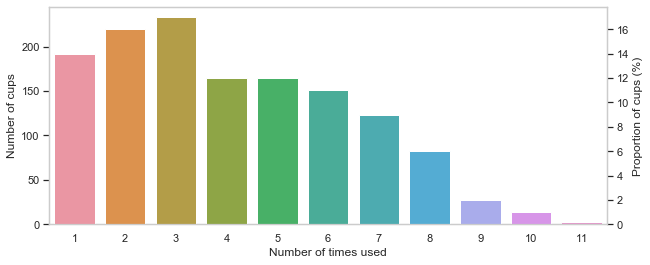

In [29]:
# generating graph
set(style="whitegrid")
fig_dims = (10, 4)
fig, ax = subplots(figsize=fig_dims)

ax1 = barplot(x="times_used", y="number_of_cups", data=numCupsByTimesUsedDF, palette=set_palette("husl"))
ax2 = ax.twinx()
ax.grid(False)
ax2.grid(False)
barplot(x="times_used", y="proportion", data = numCupsByTimesUsedDF,  ax=ax2)
ax1.set_xlabel('Number of times used')
ax1.set_ylabel('Number of cups')
ax2.set_ylabel('Proportion of cups (%)')